In [1]:
## Imports
import time
import webbrowser
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import pickle

import statsmodels.api as sm
import matplotlib

from math import sqrt

import time_series_functions as tsf

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, r2_score

plt.figure(figsize=(8, 16), dpi=80)

import autoreload
%load_ext autoreload
%autoreload 2

<Figure size 640x1280 with 0 Axes>

In [2]:
##Loading gthe datset and cleaning dups
df=pd.read_csv('AEP_hourly.csv')
#print(df.dtypes,df.shape)
df=df.groupby('Datetime').AEP_MW.mean()
df=df.reset_index()

#creating the time series
df['Datetime']=pd.to_datetime(df['Datetime'])
new_df=df.set_index(['Datetime'])

new_df.sort_index(inplace=True)
##Creating full calendar
start=new_df.index[0]
end=new_df.index[-1]
full_calendar=pd.date_range(start, end,freq='H')
##Putting it all together
calendar=pd.DataFrame(full_calendar,columns=['Datetime']).set_index('Datetime')#,new_df.head()
final_df=calendar.join(new_df)
print(final_df.isnull().sum())
final_df=final_df.interpolate()
final_df.head()
print(final_df.isnull().sum())

monthly_df=final_df[['AEP_MW']].resample('M').sum()[3:-1]
monthly_df.columns=['energy']
monthly_df.head()

AEP_MW    27
dtype: int64
AEP_MW    0
dtype: int64


,energy
Datetime,
2005-01-31,12735114.0
2005-02-28,11085745.0
2005-03-31,11847502.0
2005-04-30,10102660.5
2005-05-31,10181694.0


## Creating dataframe where to store results

In [3]:
results=pd.DataFrame(columns=['rmse'])
results

,rmse


# Splitting train and test

<AxesSubplot:title={'center':'Monthly Sales'}, xlabel='Datetime'>

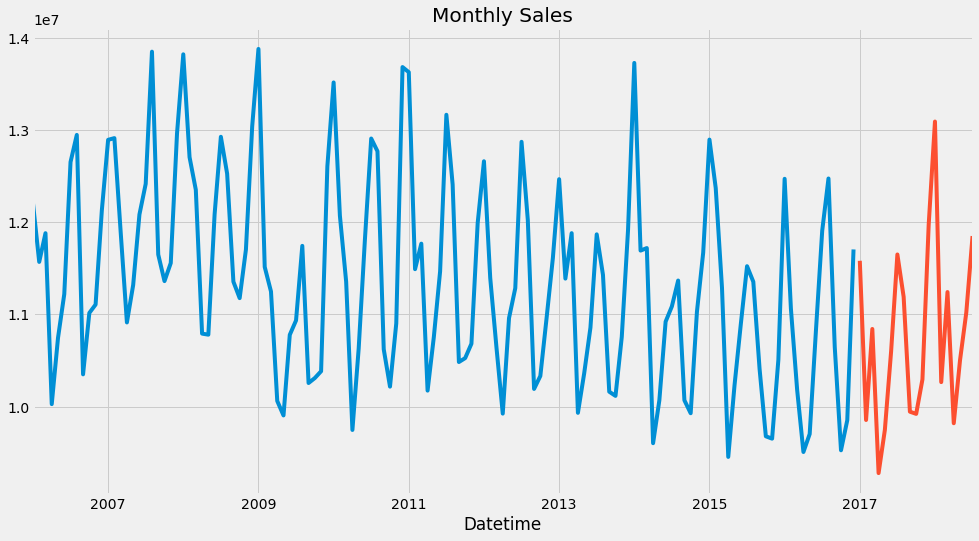

In [39]:
train=monthly_df.loc['2006':'2016'].copy()
test=monthly_df.loc['2017':'2018'].copy()
train.energy.plot(figsize=(15,8), title= 'Monthly Sales', fontsize=14)
test.energy.plot(figsize=(15,8), title= 'Monthly Sales', fontsize=14)

## 1. Naive Method: Let's pretend whatever was the last value will repeat itself in the future.

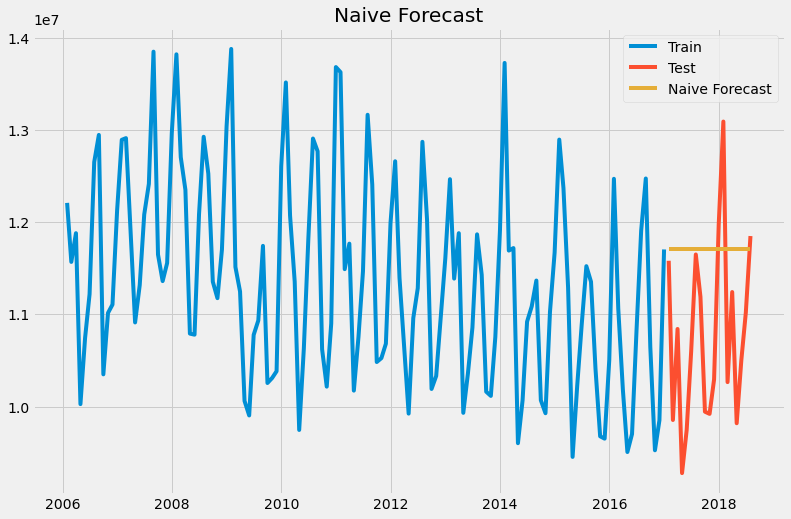

In [40]:
preds=test.copy()
preds['naive']=train[-1:].values[0][0]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['energy'], label='Train')
plt.plot(test.index,test['energy'], label='Test')
plt.plot(preds.index,preds['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast");

In [41]:
rms_naive = round(sqrt(mean_squared_error(test.energy, preds.naive)),2)
results.loc['naive']=rms_naive
results

,rmse
prophet,568170.97
holt_winter,640244.45
holt_linear,938473.78
moving_average,944047.61
arima,962103.54
SES,974246.68
simple_average,1072483.57
naive,1325608.56
sarima,2105929.01


## 2. Simple Average: Let's pretend that the future will offer the mean value of our past historywhatever was the last value will repeat itself in the future.

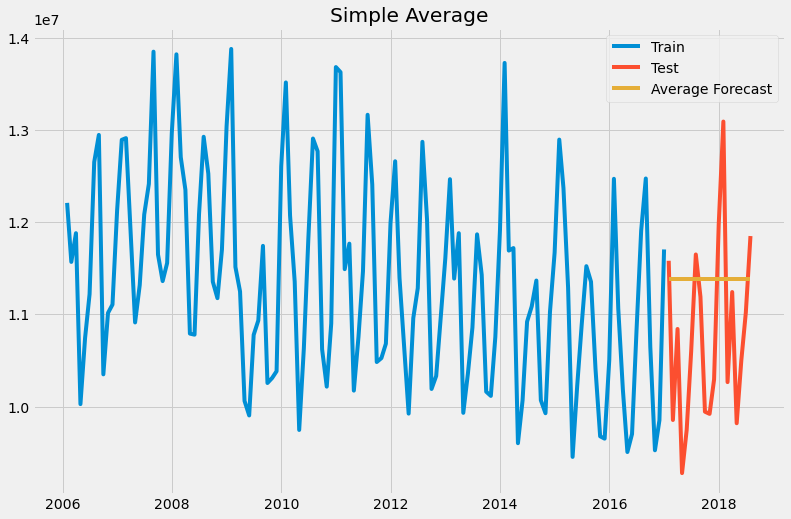

In [42]:
preds['average']=train.energy.mean()
plt.figure(figsize=(12,8))
plt.plot(train.index, train['energy'], label='Train')
plt.plot(test.index,test['energy'], label='Test')
plt.plot(preds.index,preds['average'], label='Average Forecast')
plt.legend(loc='best')
plt.title("Simple Average");

In [43]:
rms_average = round(sqrt(mean_squared_error(test.energy, preds.average)),2)
results.loc['simple_average']=rms_average
results=results.sort_values('rmse')
results

,rmse
prophet,568170.97
holt_winter,640244.45
holt_linear,938473.78
moving_average,944047.61
arima,962103.54
SES,974246.68
simple_average,1122176.88
naive,1325608.56
sarima,2105929.01


## 3. Moving Average: Let's pretend that the future will offer the mean value of our past historywhatever was the last value will repeat itself in the future.

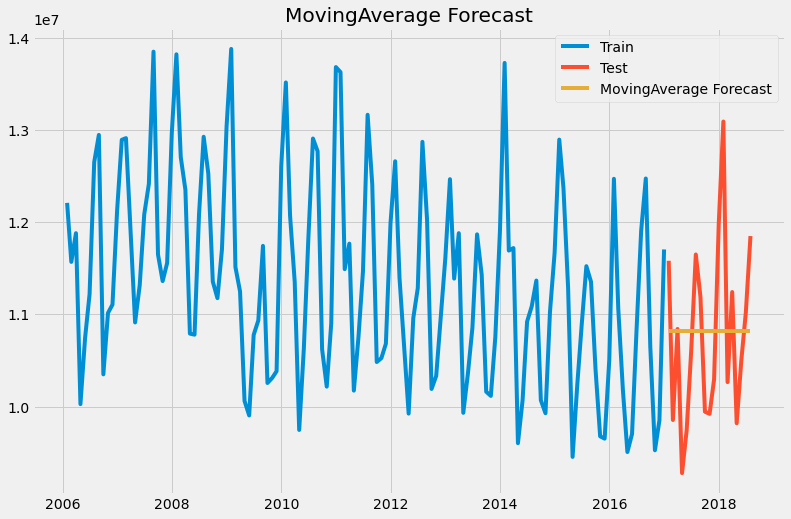

In [44]:
preds['moving_average']=train.energy.rolling(12).mean().iloc[-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['energy'], label='Train')
plt.plot(test.index,test['energy'], label='Test')
plt.plot(preds.index,preds['moving_average'], label='MovingAverage Forecast')
plt.legend(loc='best')
plt.title("MovingAverage Forecast");

In [45]:
rms_ma = round(sqrt(mean_squared_error(test.energy, preds.moving_average)),2)
results.loc['moving_average']=rms_ma
results=results.sort_values('rmse')
results

,rmse
prophet,568170.97
holt_winter,640244.45
holt_linear,938473.78
moving_average,944047.61
arima,962103.54
SES,974246.68
simple_average,1122176.88
naive,1325608.56
sarima,2105929.01


## 4. Simple Exponential Smoothing: We are giving different weights to the values depending on time. THe earlier the value occurs the less weight ity is given.

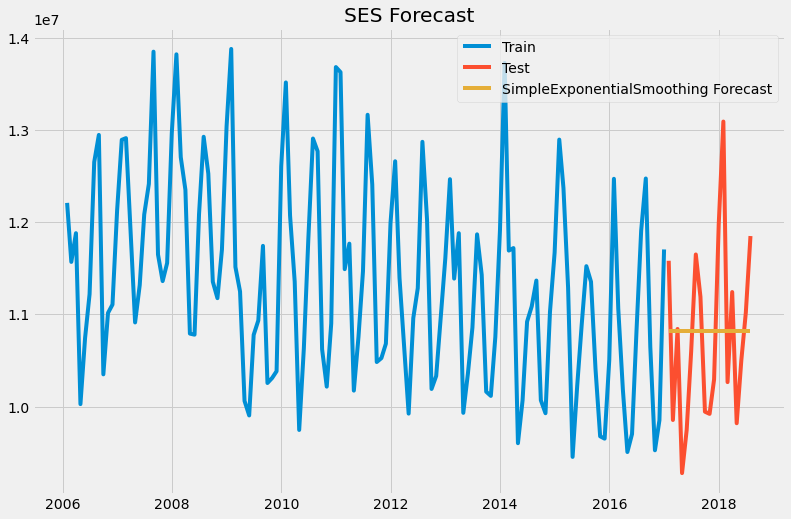

In [46]:
fit2 = SimpleExpSmoothing(train.energy).fit(smoothing_level=0.6,optimized=False)
preds['SimpleExponentialSmoothing'] = fit2.forecast(len(test))
plt.figure(figsize=(12,8))
plt.plot(train.index, train['energy'], label='Train')
plt.plot(test.index,test['energy'], label='Test')
plt.plot(preds.index,preds['moving_average'], label='SimpleExponentialSmoothing Forecast')
plt.legend(loc='best')
plt.title("SES Forecast");

In [47]:
rms_ses = round(sqrt(mean_squared_error(test.energy, preds.SimpleExponentialSmoothing)),2)
results.loc['SES']=rms_ses
results=results.sort_values('rmse')
results

,rmse
prophet,568170.97
holt_winter,640244.45
holt_linear,938473.78
moving_average,944047.61
arima,962103.54
SES,974246.68
simple_average,1122176.88
naive,1325608.56
sarima,2105929.01



## 5. Holt's Linear Trend: We are adding the trend to the SES to make forecasts

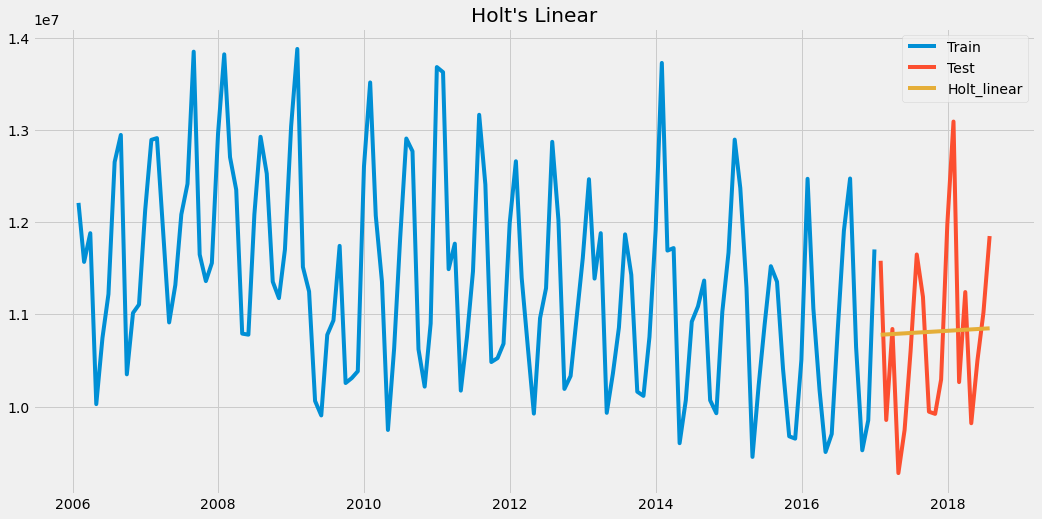

In [48]:
fit1 = Holt(train.energy).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
preds['holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds['holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.title("Holt's Linear");
plt.show()

In [49]:
rms_holt = round(sqrt(mean_squared_error(test.energy, preds.holt_linear)),2)
results.loc['holt_linear']=rms_holt
results=results.sort_values('rmse')
results

,rmse
prophet,568170.97
holt_winter,640244.45
holt_linear,938473.78
moving_average,944047.61
arima,962103.54
SES,974246.68
simple_average,1122176.88
naive,1325608.56
sarima,2105929.01


## 6. Holt's Winter: Let's add the seasonality to make forecasts

/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


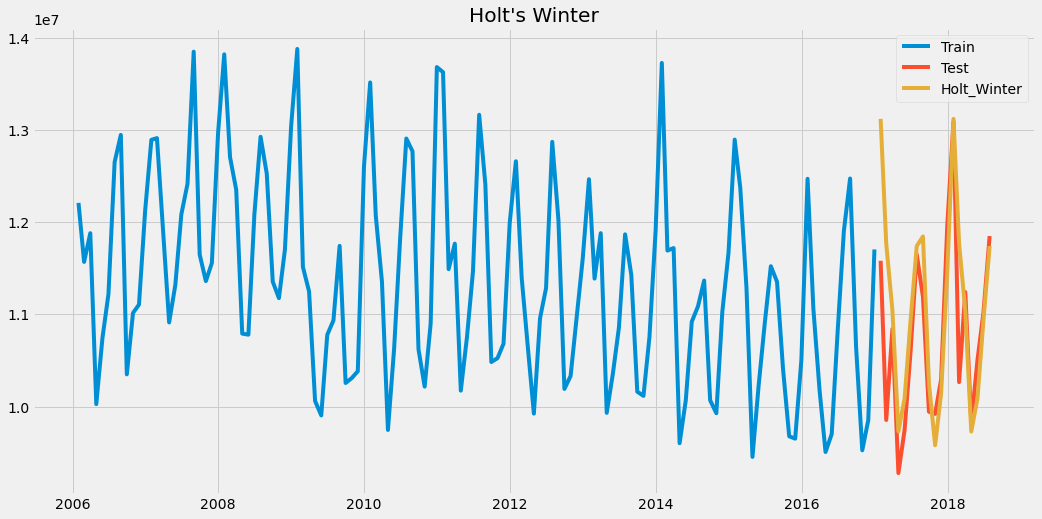

In [50]:

fit1 = ExponentialSmoothing(train.energy ,seasonal_periods=12 ,trend='add', seasonal='add',).fit()
preds['holt_winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds.holt_winter, label='Holt_Winter')
plt.legend(loc='best')
plt.title("Holt's Winter");
plt.show()

In [16]:
rms_holtwinter = round(sqrt(mean_squared_error(test.energy, preds.holt_winter)),2)
results.loc['holt_winter']=rms_holtwinter
results=results.sort_values('rmse')
results

,rmse
holt_winter,640244.45
holt_linear,938473.78
moving_average,944047.61
SES,974246.68
simple_average,1072483.57
naive,1325608.56


## 7: ARIMA---AR for AutoRegressive, I for Integrated and MA for moving average

In [51]:
with open('best_parameters.pkl', 'rb') as f:
    bp=pickle.load(f)
bp['monthly']

[(1, 2, 2),
 (1, 0, 2, 12),

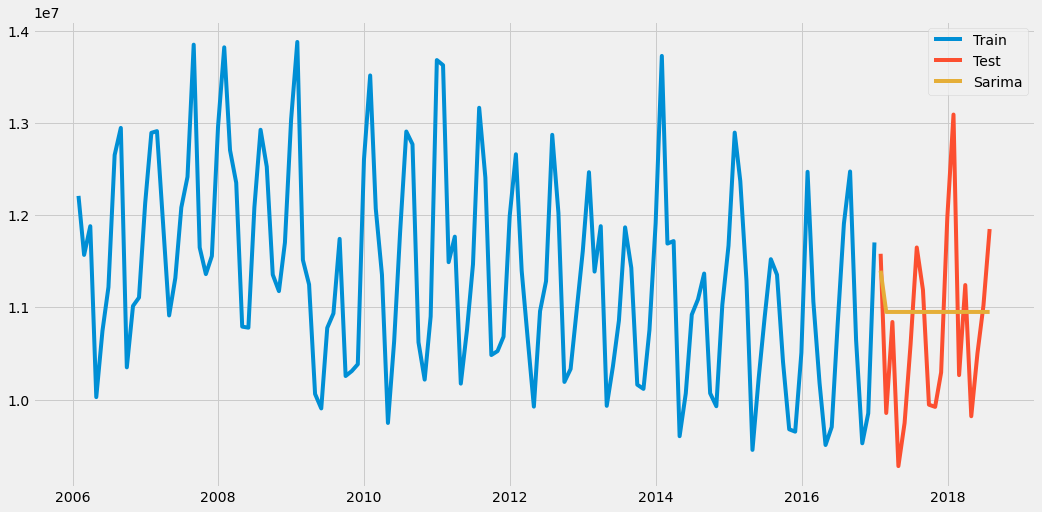

In [53]:
model = ARIMA(train.energy, order=(0, 1, 2))
model_fit = model.fit()
# make prediction
preds['arima'] = model_fit.predict(start = len(train), end =len(train)+len(test), dynamic= True)
plt.figure(figsize=(16,8))
plt.plot( train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds.arima, label='Sarima')
plt.legend(loc='best')
plt.show()

In [54]:
rms_arima = round(sqrt(mean_squared_error(test.energy, preds.arima)),2)
results.loc['arima']=rms_arima
results=results.sort_values('rmse')
results

,rmse
prophet,568170.97
holt_winter,640244.45
holt_linear,938473.78
moving_average,944047.61
arima,949437.90
SES,974246.68
simple_average,1122176.88
naive,1325608.56
sarima,2105929.01


## 8: SARIMA. Adding seasonality to ARIMA

In [55]:
bp['monthly']

[(1, 2, 2),
 (1, 0, 2, 12),

In [38]:
train.shape

(108, 1)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55153D+01    |proj g|=  1.06741D+00

At iterate    5    f=  1.50087D+01    |proj g|=  6.16488D-02

At iterate   10    f=  1.49874D+01    |proj g|=  4.38015D-02

At iterate   15    f=  1.49696D+01    |proj g|=  8.86673D-03

At iterate   20    f=  1.49691D+01    |proj g|=  5.72192D-03

At iterate   25    f=  1.49691D+01    |proj g|=  1.52671D-03

At iterate   30    f=  1.49687D+01    |proj g|=  9.79471D-03

At iterate   35    f=  1.49684D+01    |proj g|=  7.78982D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

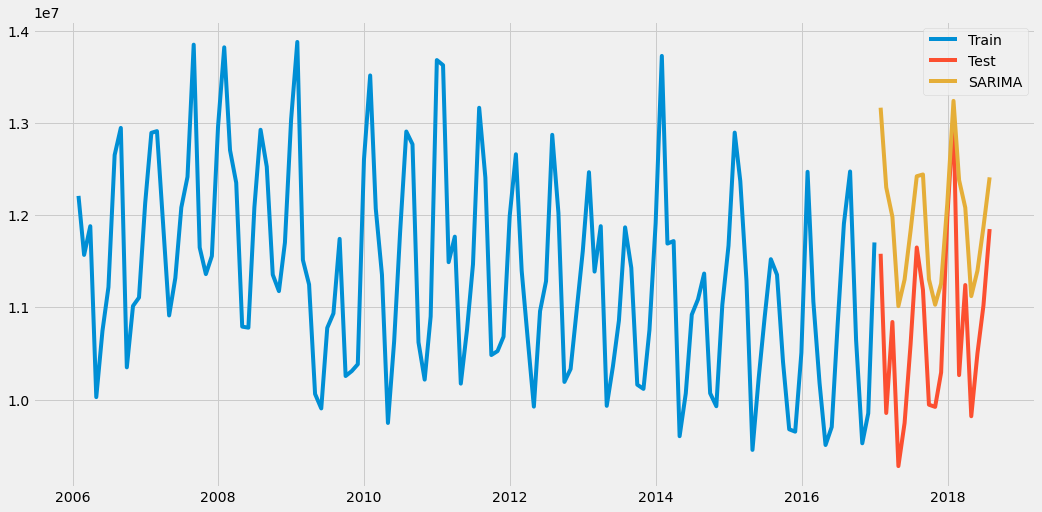

In [56]:
#(0, 1, 2), (0, 1, 2, 12)
#(2, 2, 2), (2, 2, 0, 12)
train_s=train[-150:].copy()
fit1 = sm.tsa.statespace.SARIMAX(train_s.energy, order=bp['monthly'][0],seasonal_order=bp['monthly'][1]).fit()
preds['sarima'] = fit1.predict(start = len(train_s), end =len(train_s)+len(test), dynamic= False)
plt.figure(figsize=(16,8))
plt.plot( train_s.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds.sarima, label='SARIMA')
plt.legend(loc='best')
plt.show()

In [57]:
rms_sarima = round(sqrt(mean_squared_error(test.energy, preds.sarima)),2)
results.loc['sarima']=rms_sarima
results=results.sort_values('rmse')
results

,rmse
prophet,568170.97
holt_winter,640244.45
holt_linear,938473.78
moving_average,944047.61
arima,949437.90
SES,974246.68
simple_average,1122176.88
sarima,1290570.66
naive,1325608.56


## 9: Prophet. Asking for help to FaceBook.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02245
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       739.001   0.000617642       937.786           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       741.926    0.00472146       680.658           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       743.084   0.000375223       537.264           1           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       745.648   0.000431694        205.28      0.7341      0.7341      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       746.186   4.91786e-05       143.385      0.6402      0.6402      602   
    Iter      log prob        ||dx||      ||grad||       alpha  

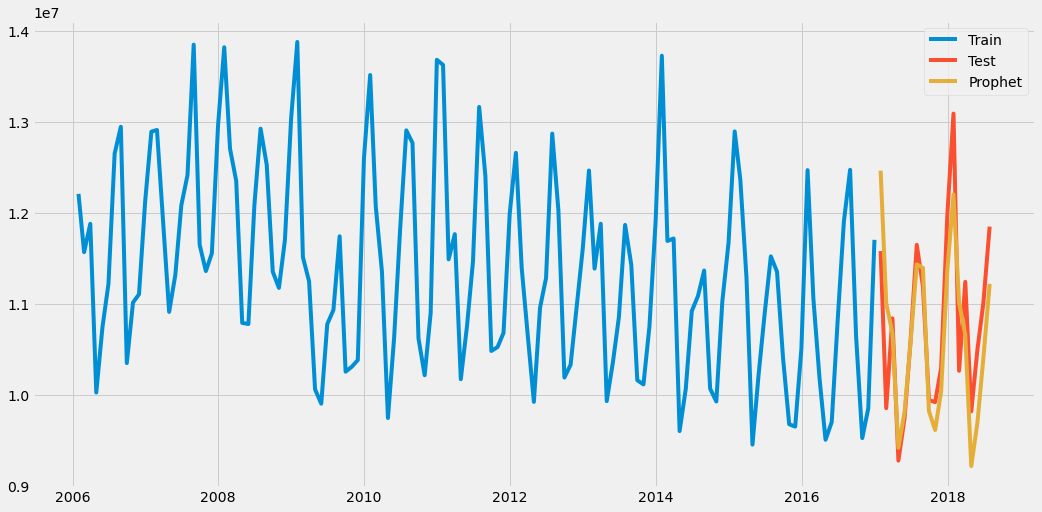

In [58]:
#Prophet

seasonality=12

freq='M'
####Prepping for Prophet
pro_train=train.reset_index()

pro_train.rename(columns={'energy':'y','Datetime':'ds'}, inplace = True)

pro_train['y'] = np.log(pro_train['y'])
model = Prophet()
model.fit(pro_train)
future = model.make_future_dataframe(periods=len(test), freq = 'M')
forecast = model.predict(future)
pro_preds=forecast.set_index('ds').yhat.tail(len(test)).values
preds['fbp_preds']=np.exp(pro_preds)
plt.figure(figsize=(16,8))
plt.plot( train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds.fbp_preds, label='Prophet')
plt.legend(loc='best')
plt.show()

In [59]:
rms_prophet = round(sqrt(mean_squared_error(test.energy, preds.fbp_preds)),2)
results.loc['prophet']=rms_prophet
results=results.sort_values('rmse')
results

,rmse
prophet,573277.86
holt_winter,640244.45
holt_linear,938473.78
moving_average,944047.61
arima,949437.90
SES,974246.68
simple_average,1122176.88
sarima,1290570.66
naive,1325608.56


In [61]:
results.to_csv('scores.csv')